In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#Import data for processing

filename = "./19-08-2020/FLPID_circle1.xlsx"
data = pd.read_excel(filename, 
                    names = ["globaltime","dt",'rb1x','rb1y','rb1z','rb2x','rb2y','rb2z',
                            'rb3x','rb3y','rb3z','rb4x','rb4y','rb4z','rb5x','rb5y','rb5z',
                            'rb6x','rb6y','rb6z','rb7x','rb7y','rb7z','rb8x','rb8y','rb8z',
                            'xd','yd','thetad'])
while data.iloc[0]['rb1z']==0.0:    
    data = data.drop(0)
    data.index-=1
      
data.iloc[0]['rb1z']        
data


,globaltime,dt,rb1x,rb1y,rb1z,rb2x,rb2y,rb2z,rb3x,rb3y,...,rb6z,rb7x,rb7y,rb7z,rb8x,rb8y,rb8z,xd,yd,thetad
0,0.029785,0.02,553.403405,633.141383,97.692416,455.924949,691.698157,96.342519,131.967843,888.491060,...,89.419131,451.377414,457.941582,94.618584,548.383354,511.002776,95.449946,0.004679,0.999989,0
1,0.049895,0.02,553.345504,633.133757,97.758386,455.924874,691.754682,96.334731,131.997513,888.570475,...,89.376695,451.410586,457.961500,94.610082,548.406469,511.055500,95.442040,0.007837,0.999969,0
2,0.077264,0.02,553.395645,633.346578,97.617643,455.915707,691.709225,96.302008,131.988996,888.543570,...,89.336659,451.411426,457.939608,94.610909,548.401522,511.052723,95.434950,0.012136,0.999926,0
3,0.110636,0.02,553.375485,632.799065,98.128742,455.910003,691.727945,96.354039,132.007485,888.557375,...,89.453008,451.394513,457.992293,94.596087,548.413285,511.061243,95.455260,0.017378,0.999849,0
4,0.129512,0.02,553.282292,632.971307,97.898704,455.904039,691.706610,96.317998,132.019339,888.368317,...,89.389662,451.408223,457.953083,94.606855,548.416262,511.022625,95.414094,0.020342,0.999793,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,41.973046,0.02,631.088418,1643.654075,107.331841,535.870752,1705.146333,104.494091,218.522504,1912.571332,...,107.462538,523.101688,1471.386840,108.266146,622.145290,1521.216703,107.672366,0.304988,0.952356,0
2044,41.991666,0.02,634.197666,1643.422519,107.372593,538.919176,1704.915680,104.523892,221.625071,1912.329211,...,107.440488,526.457839,1471.064743,108.320056,625.287409,1521.106228,107.636400,0.307772,0.951460,0
2045,42.011499,0.02,637.679689,1643.300278,107.487223,542.054548,1704.668189,104.520413,224.713352,1912.052946,...,107.393952,529.581269,1470.811806,108.336179,628.435230,1520.809891,107.642322,0.310734,0.950497,0
2046,42.031426,0.02,640.638766,1642.880965,107.570802,545.235627,1704.355489,104.655849,227.726290,1911.533934,...,107.358240,532.748305,1470.606976,108.297009,631.598359,1520.556729,107.638036,0.313708,0.949519,0


In [3]:
#calculate robot position at each point

#calculate the center of the robot
Adet = (data['rb1x']*(data['rb4y']-data['rb6y']) -
       data['rb1y']*(data['rb4x']-data['rb6x']) +
       data['rb4x']*data['rb6y']-data['rb6x']*data['rb4y'])

Bdet = ((data['rb1x']**2+data['rb1y']**2)*(data['rb6y']-data['rb4y'])  +
       (data['rb4x']**2+data['rb4y']**2)*(data['rb1y']-data['rb6y'])  +
       (data['rb6x']**2+data['rb6y']**2)*(data['rb4y']-data['rb1y']) )

Cdet = ((data['rb1x']**2+data['rb1y']**2)*(data['rb4x']-data['rb6x'])  +
       (data['rb4x']**2+data['rb4y']**2)*(data['rb6x']-data['rb1x'])  +
       (data['rb6x']**2+data['rb6y']**2)*(data['rb1x']-data['rb4x']) )

x_r = -Bdet/(2.*Adet)/1000. #robot global position x in meters 
y_r = -Cdet/(2.*Adet)/1000. #robot global position y in meters


x_mid = (data['rb1x']+data['rb8x'])/2. #calculate the midpoint of wheel 1
y_mid = (data['rb1y']+data['rb8y'])/2.

#rotate desired position to be in line with robot
xd_rot = data['xd']*np.cos(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))-data['yd']*np.sin(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))
yd_rot = data['yd']*np.cos(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))+data['xd']*np.sin(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))

#set robot initial position to the origin
x_r = x_r+Bdet[0]/(2.*Adet[0])/1000. #robot position x in meters starting at origin
y_r = y_r+Cdet[0]/(2.*Adet[0])/1000. #robot global position y in meters  starting at origin
theta_r = np.arctan2(y_mid-y_r,x_mid-x_r) - np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]) #robot angle starting at 0

In [4]:
#cast robot info into a new dataframe

pdata = pd.DataFrame()
pdata.insert(0,"globaltime", data['globaltime'],True)
pdata.insert(1, "x_r", x_r,True)
pdata.insert(2, "y_r", y_r,True)
pdata.insert(3, "theta_r", theta_r,True)
pdata.insert(4, "x_d", xd_rot,True)
pdata.insert(5, "y_d", yd_rot,True)
pdata.insert(6, "theta_d", data['thetad'],True)
pdata


,globaltime,x_r,y_r,theta_r,x_d,y_d,theta_d
0,0.029785,0.000000,0.000000,0.000000,-0.716854,0.697223,0
1,0.049895,-0.000021,0.000034,0.000035,-0.714648,0.699484,0
2,0.077264,0.000035,0.000062,0.000107,-0.711634,0.702550,0
3,0.110636,-0.000054,0.000028,-0.000125,-0.707942,0.706271,0
4,0.129512,-0.000062,0.000001,-0.000026,-0.705845,0.708367,0
...,...,...,...,...,...,...,...
2043,41.973046,0.076065,1.020621,0.389323,-0.474181,0.880428,0
2044,41.991666,0.079217,1.020337,0.387581,-0.471604,0.881811,0
2045,42.011499,0.082565,1.020075,0.385729,-0.468854,0.883276,0
2046,42.031426,0.085638,1.019700,0.383989,-0.466087,0.884739,0


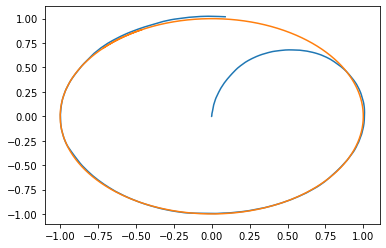

In [5]:
plt.plot(pdata['x_r'],pdata['y_r'],pdata['x_d'],pdata['y_d'])
plt.show()